In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import brewer2mpl
import colorsys
import math
import dendropy as dp
import json
import os

from datetime import datetime
from Bio import AlignIO, SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Levenshtein import distance
from itertools import combinations, product, permutations
from time import time
from __future__ import division
from collections import Counter, defaultdict
from copy import deepcopy
from random import shuffle, choice, sample
from scipy.stats.mstats import mquantiles
from scipy.stats import norm, expon, poisson, binom
from scipy.misc import comb
from IPython.display import Math, clear_output
from networkx.readwrite import json_graph 

%matplotlib inline

# Introduction

A transition profile is the host-to-host transition profile for each subgraph.

In [2]:
if os.getcwd().split('/')[-1] == 'All_IRD_Analysis_Run2':
    os.chdir('subgraph_pkl')
subgraphs = dict()
counter = 0
for f in os.listdir(os.getcwd()):
    if f.split('.')[-1] == 'pkl':
        i = f.split('_')[0]
        g = nx.read_gpickle('{0}'.format(f))
        subgraphs[counter] = g
        counter += 1
    
if os.getcwd().split('/')[-1] == 'subgraph_pkl':
    os.chdir('..')


In [3]:
subgraph_sizes = dict()
for i, subgraph in subgraphs.items():
    subgraph_sizes[i] = len(subgraph.nodes())
subgraph_sizes

{0: 6,
 1: 144,
 2: 6,
 3: 1,
 4: 2,
 5: 1,
 6: 1,
 7: 1,
 8: 2,
 9: 1,
 10: 1,
 11: 1,
 12: 1,
 13: 2,
 14: 241,
 15: 1,
 16: 7,
 17: 1,
 18: 1,
 19: 1,
 20: 1,
 21: 1,
 22: 2,
 23: 1,
 24: 2,
 25: 23,
 26: 1,
 27: 1,
 28: 1,
 29: 1,
 30: 2,
 31: 1,
 32: 2,
 33: 1,
 34: 1,
 35: 1,
 36: 6,
 37: 1,
 38: 1,
 39: 1,
 40: 1,
 41: 2,
 42: 1,
 43: 2,
 44: 1,
 45: 1,
 46: 1,
 47: 91,
 48: 1,
 49: 1,
 50: 1,
 51: 1,
 52: 1,
 53: 1,
 54: 1,
 55: 1,
 56: 1,
 57: 2,
 58: 5,
 59: 1,
 60: 2,
 61: 1,
 62: 1,
 63: 1,
 64: 1,
 65: 1,
 66: 1,
 67: 1,
 68: 1,
 69: 6,
 70: 4,
 71: 1,
 72: 1,
 73: 1,
 74: 1,
 75: 1,
 76: 1,
 77: 2,
 78: 1,
 79: 1,
 80: 5,
 81: 2,
 82: 1,
 83: 1,
 84: 1,
 85: 1,
 86: 1,
 87: 1,
 88: 1,
 89: 2,
 90: 1,
 91: 1,
 92: 2,
 93: 1,
 94: 1,
 95: 2,
 96: 1,
 97: 2,
 98: 1,
 99: 1,
 100: 1,
 101: 1,
 102: 1,
 103: 1,
 104: 1,
 105: 1,
 106: 3,
 107: 1,
 108: 1,
 109: 1,
 110: 2,
 111: 1,
 112: 2,
 113: 291,
 114: 2,
 115: 1,
 116: 1,
 117: 1,
 118: 2,
 119: 1,
 120: 1,
 121: 2,
 122

In [4]:
# Let's make the transition matrix for each subgraph.
def get_graph_of_interest(subgraph_list, subgraph_idx):
    goi = nx.DiGraph(subgraph_list[subgraph_idx])
    for source, sink in goi.edges():
        if goi.node[source]['collection_date'] >= goi.node[sink]['collection_date']:
            goi.remove_edge(source, sink)
            
    return goi

# Initialize a dictionary for the transition matrix.
def initialize_transition_matrix(labels):
    """
    Pass in a list of labels that define what the transitions are.
    """
    transition_matrix = dict()
    for t1 in labels:
        if t1 not in transition_matrix.keys():
            transition_matrix[t1] = dict()
        for t2 in labels:
            transition_matrix[t1][t2] = 0
            
    return transition_matrix

# Count the source-sink relationships
def compute_transition_matrix(goi, transition_matrix):
    for source, sink, data in goi.edges(data=True):
        source_host = goi.node[source]['host_species']
        sink_host = goi.node[sink]['host_species']

        if '/' in source_host:
            source_host = source_host.split('/')[1]
        if '/' in sink_host:
            sink_host = sink_host.split('/')[1]
        if sink_host not in host_types: 
            sink_host = 'Other'
        if source_host not in host_types:
            source_host = 'Other'

        transition_matrix[source_host][sink_host] += 1
        
    return transition_matrix

# # Sample code below
# goi = get_graph_of_interest(subgraphs, 1661)
# transition_matrix = initialize_transition_matrix(host_types)
# transition_matrix = compute_transition_matrix(goi, transition_matrix)
# transition_matrix

(array([  4.,   1.,   3.,  11.,   4.,   6.,  13.,  45.,  43.,  17.]),
 array([ 7.691758 ,  7.7222042,  7.7526504,  7.7830966,  7.8135428,
         7.843989 ,  7.8744352,  7.9048814,  7.9353276,  7.9657738,  7.99622  ]),
 <a list of 10 Patch objects>)

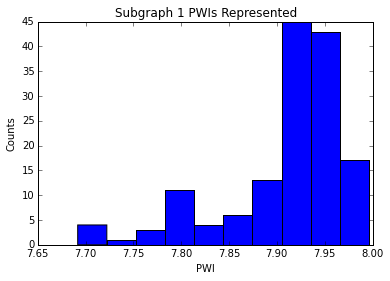

In [5]:
# Get a histogram of the PWIs represented
def get_pwi_histogram(subgraphs, idx):
    pwis = []
    goi = subgraphs[idx]
    
    for source, sink, data in goi.edges(data=True):
        pwis.append(data['pwi'])
        
    fig = plt.figure()
    plt.xlabel('PWI')
    plt.ylabel('Counts')
    plt.title('Subgraph {0} PWIs Represented'.format(idx))
    if len(set(pwis)) == 1:
        fig = plt.hist(pwis, range=(pwis[0]-0.5, pwis[0]+0.5))
    else:
        fig = plt.hist(pwis)
    return fig

get_pwi_histogram(subgraphs, 1)


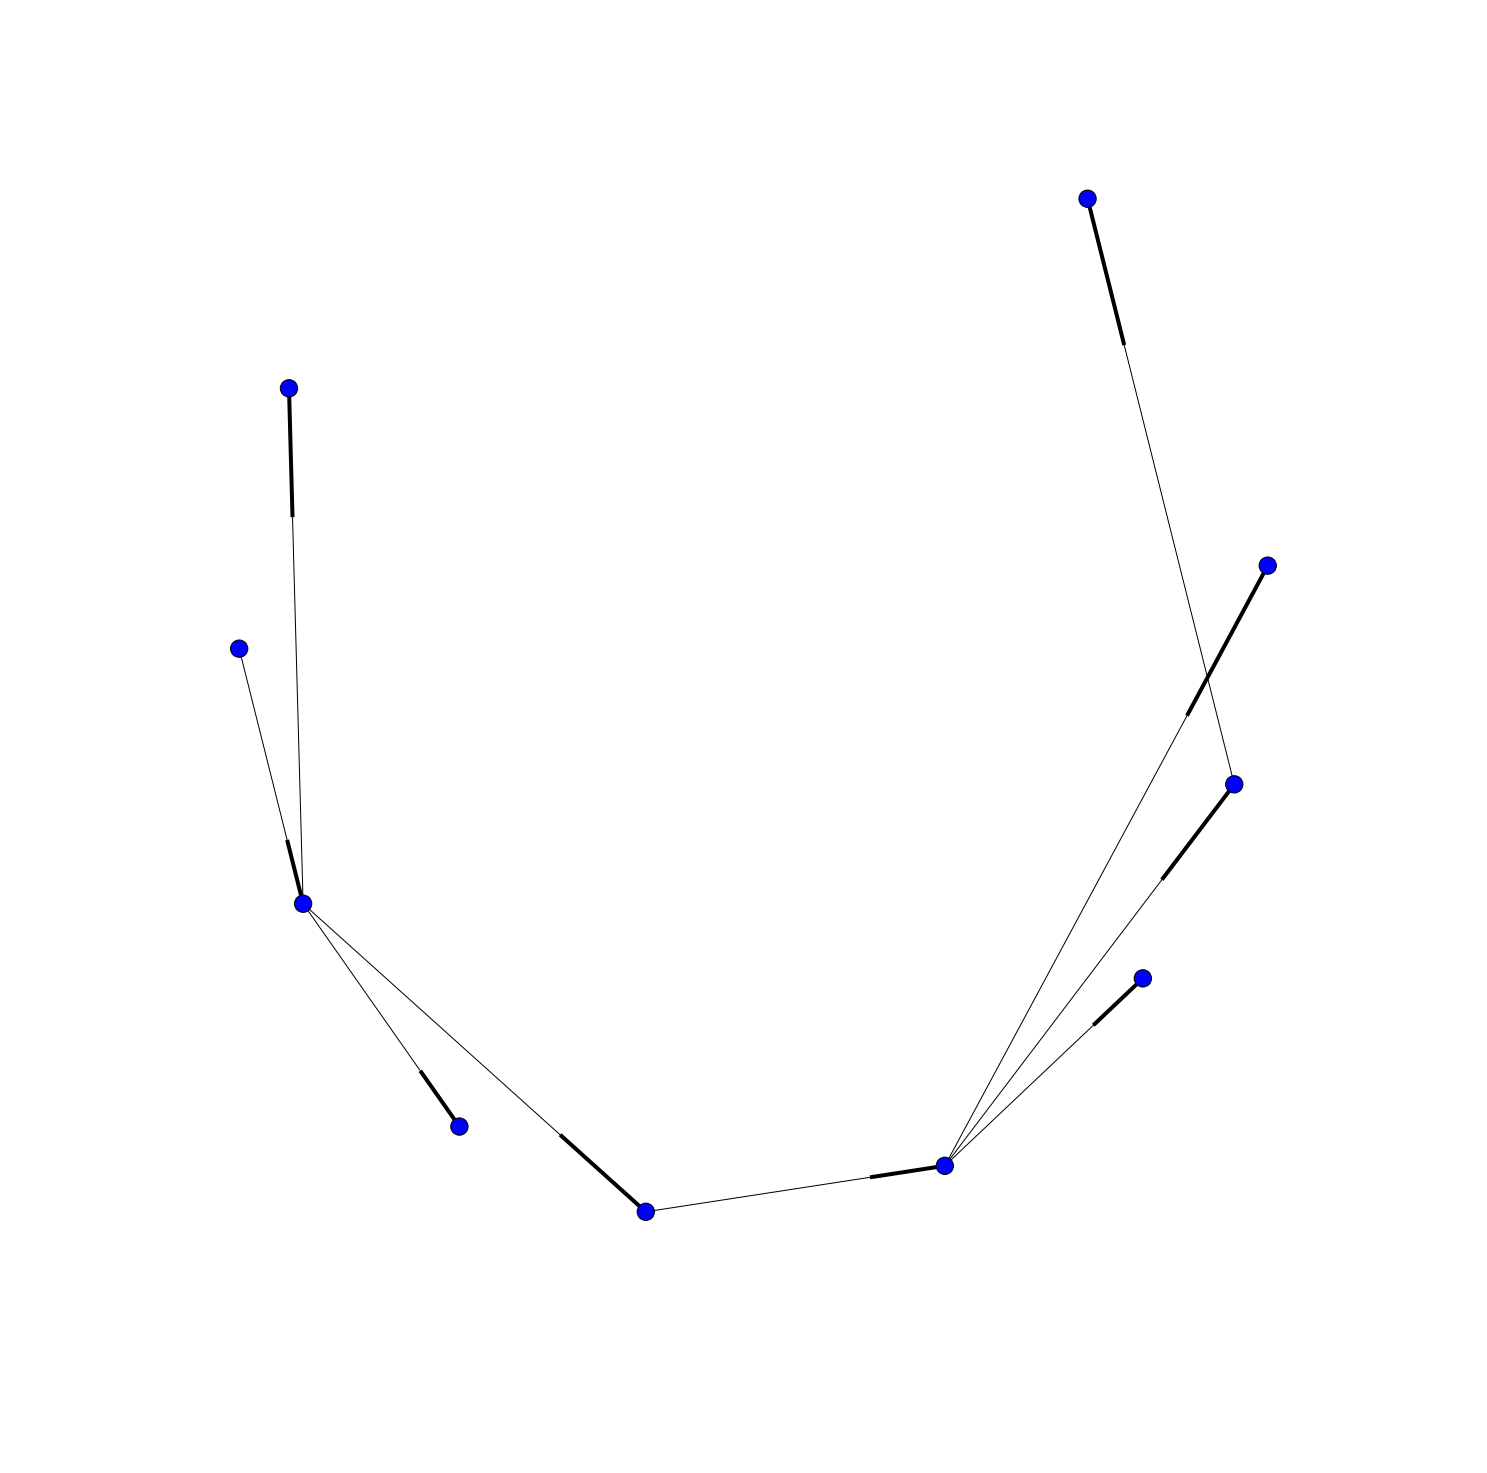

In [6]:
def plot_network(goi):
    fig = plt.figure(figsize=(20, 20))
    colormap = {'Human':'red', 'Avian':'blue', 'Swine':'green', 'Environment':'orange', 'Other':'pink'}
    labels = list()
    for n, d, in goi.nodes(data=True):
        host = d['host_species']
        if '/' in host:
            host = host.split('/')[1]
        if host not in colormap.keys():
            host = 'Other'
        labels.append(host)
    colors = [colormap[l] for l in labels]
    fig = nx.draw(goi, node_color=colors)
    return fig
plot_network(subgraphs[546])

In [8]:
def table_transition_matrix(transition_matrix_dictionary):
    tmatrix_df = pd.DataFrame(transition_matrix_dictionary).T
    tmatrix_df.loc['Environment', 'Avian']
    return tmatrix_df

In [10]:
def plot_transition_matrix(tmatrix_df, subgraph_idx):
    fig = plt.figure(figsize=(6,6))
    fig = plt.pcolor(tmatrix_df, cmap='Greens')
    plt.xticks(np.arange(len(tmatrix_df.index))+0.5, tmatrix_df.index)
    plt.xlabel('Destination')
    plt.yticks(np.arange(len(tmatrix_df.index))+0.5, tmatrix_df.index)
    plt.ylabel('Source')
    plt.title('Subgraph {0} Transition Matrix'.format(subgraph_idx))
    return fig

In [11]:
[d['pwi'] for _,_,d in subgraphs[56].edges(data=True)]

[]

In [12]:
import os

if 'subgraph_plots' not in os.listdir(os.getcwd()):
    os.mkdir('subgraph_plots')

host_types = ['Avian', 'Human' , 'Swine', 'Environment', 'Other']

for i, subgraph in subgraphs.items():
    if len(subgraph.edges()) > 1:
        goi = subgraphs[i]

        transition_matrix = initialize_transition_matrix(host_types)
        transition_matrix = compute_transition_matrix(goi, transition_matrix)
        network_plot = plot_network(goi)
        plt.savefig('subgraph_plots/{0} Network.pdf'.format(i))
        clear_output() 
        plt.close()
        # Plot transition matrix and save PDF & CSV versions of them. 
        tmatrix_df = table_transition_matrix(transition_matrix)
        tmatrix_df.to_csv('subgraph_plots/{0} Transition Matrix.csv'.format(i))
        plt.figure()
        transition_matrix_plot = plot_transition_matrix(tmatrix_df, i)
        plt.savefig('subgraph_plots/{0} Transition Matrix.pdf'.format(i))
        plt.close()
        clear_output()
        
        pwi_histogram = get_pwi_histogram(subgraphs, i)
        plt.savefig('subgraph_plots/{0} PWI Histogram.pdf'.format(i))
        plt.close()
        clear_output()